# Task 2

### Method 1

In [ ]:
import os
from PyPDF2 import PdfReader
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text

def generate_vectors(folder_path, model_path='doc2vec.model'):
    """
    Extract text from PDFs in folders and generate two lists of vectors.
    Each subfolder should contain at least two PDFs.
    """
    first_pdf_texts = []
    second_pdf_texts = []

    # Traverse through the 5 folders
    for subfolder in sorted(os.listdir(folder_path)):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            pdf_files = sorted(
                [f for f in os.listdir(subfolder_path) if f.endswith('.pdf')]
            )
            if len(pdf_files) >= 2:
                # Extract text from the first and second PDFs
                first_pdf_path = os.path.join(subfolder_path, pdf_files[0])
                second_pdf_path = os.path.join(subfolder_path, pdf_files[1])

                first_pdf_texts.append(extract_text_from_pdf(first_pdf_path))
                second_pdf_texts.append(extract_text_from_pdf(second_pdf_path))

    # Combine all texts for doc2vec training
    all_texts = first_pdf_texts + second_pdf_texts
    tagged_data = [
        TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(all_texts)
    ]

    # Train Doc2Vec model
    model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20)
    model.save(model_path)

    # Generate vectors for first and second PDF texts
    first_pdf_vectors = [model.infer_vector(text.split()) for text in first_pdf_texts]
    second_pdf_vectors = [model.infer_vector(text.split()) for text in second_pdf_texts]

    return first_pdf_vectors, second_pdf_vectors

# Example usage
folder_path = "Data/Reference/Publishable"  # Replace with your folder path
first_vectors, second_vectors = generate_vectors(folder_path)

In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_closest_vector(training_vectors, new_vector):
    """
    Find the index of the closest vector to the new vector among the training vectors.
    
    Args:
        training_vectors (list or np.ndarray): List or array of training vectors.
        new_vector (np.ndarray): The new vector to compare.
    
    Returns:
        int: Index of the closest vector in the training vectors.
    """
    training_vectors = np.array(training_vectors)  # Ensure it's a NumPy array
    new_vector = np.array(new_vector).reshape(1, -1)  # Reshape to match dimensions
    similarities = cosine_similarity(training_vectors, new_vector)
    closest_index = np.argmax(similarities)  # Index of the highest similarity
    return closest_index

# Example usage
# Assuming `first_vectors` contains the training vectors from the first PDF of each folder
new_vector = second_vectors[4]  # Replace with your new vector
closest_index = find_closest_vector(first_vectors, new_vector)

print(f"The index of the closest vector is: {closest_index}")

The index of the closest vector is: 4


In [3]:
for i in range(5):
    new_vector = second_vectors[i]  # Replace with your new vector
    closest_index = find_closest_vector(first_vectors, new_vector)
    print(f"The index of the closest vector is: {closest_index}")

The index of the closest vector is: 0
The index of the closest vector is: 1
The index of the closest vector is: 1
The index of the closest vector is: 3
The index of the closest vector is: 4


The predicted classes should be - 0, 1, 2, 3, 4 but the KDD has been wrongly identified as EMNLP

### Method 2

Matching the abstact of the papers with generalised fields under AI to classify them into the conferences that specialise in that field.

In [4]:
train_sentences=["Computer Vision",
                 "Image Processing",
                 "extracting structures or answers from images or video or applying mathematical methods to data to extract or recognize patterns.",
"Natural language processing",
"Part-of-speech tagging, parsing, and named entity recognition",
"Data Mining", 
"large-scale data analytics",
"Knowledge discovery through data analysis"
"Neural Information processing systems",
"neuroscience",
"optimization",
"life sciences, and social sciences",
"computational and mathematical principles behind machine learning",
"theoretical studies on learning systems"] # Generalised fields

In [5]:
from sentence_transformers import SentenceTransformer
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name) # import the relevant sentence transformer to run the similarity search

e:\Projects\ProjectEnvironment\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [6]:
train_embed = [model.encode(i) for i in train_sentences] # embed the sentences containing the fields

In [ ]:
def extract_title_and_abstract(pdf_path):
    """
    Extracts the title and abstract from a PDF.
    Title: Text from start to '\nAbstract\n'.
    Abstract: Text between '\nAbstract\n' and '1 Introduction'.
    """
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()

    # Extract title
    title_end = text.find("\nAbstract\n")
    title = text[:title_end].strip() if title_end != -1 else ""

    # Extract abstract
    abstract_start = text.find("\nAbstract\n") + len("\nAbstract\n")
    abstract_end = text.find("1 Introduction")
    abstract = text[abstract_start:abstract_end].strip() if abstract_start != -1 and abstract_end != -1 else ""

    return title, abstract

def embed_texts(folder_path, model_name='all-MiniLM-L6-v2'):
    """
    Extracts and embeds titles and abstracts from PDFs in folder structure.
    Assigns labels based on folder names.
    
    Returns:
        tuple: Title embeddings, Abstract embeddings, Labels for each.
    """
    model = SentenceTransformer(model_name)
    titles, abstracts, labels = [], [], []

    for subfolder in sorted(os.listdir(folder_path)):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder  # Use folder name as label
            pdf_files = sorted([f for f in os.listdir(subfolder_path) if f.endswith('.pdf')])

            for pdf_file in pdf_files:
                pdf_path = os.path.join(subfolder_path, pdf_file)

                # Extract title and abstract
                title, abstract = extract_title_and_abstract(pdf_path)

                # Embed title and abstract
                if title:
                    title_embedding = model.encode(title)
                    titles.append(title_embedding)
                    labels.append(label)

                if abstract:
                    abstract_embedding = model.encode(abstract)
                    abstracts.append(abstract_embedding)

    return titles, abstracts, labels

# Example usage
folder_path = "Data/Reference/Publishable"  # Replace with your folder path
titles, abstracts, labels = embed_texts(folder_path, model_name=model_name) # embed all the publishable papers and get their labels

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def find_closest_vector(training_vectors, new_vector):
    """
    Find the index of the closest vector to the new vector among the training vectors.
    
    Args:
        training_vectors (list or np.ndarray): List or array of training vectors.
        new_vector (np.ndarray): The new vector to compare.
    
    Returns:
        int: Index of the closest vector in the training vectors.
    """
    training_vectors = np.array(training_vectors)  # Ensure it's a NumPy array
    new_vector = np.array(new_vector).reshape(1, -1)  # Reshape to match dimensions
    similarities = cosine_similarity(training_vectors, new_vector)
    closest_index = np.argmax(similarities)  # Index of the highest similarity
    return closest_index

Using KNN with k=1 

In [11]:
for i in range(len(titles)): # using the title embedding as input to the KNN
    index = find_closest_vector(train_embed, titles[i])
    print(labels[i])
    print(train_sentences[index])

CVPR
Computer Vision
CVPR
extracting structures or answers from images or video or applying mathematical methods to data to extract or recognize patterns.
EMNLP
Part-of-speech tagging, parsing, and named entity recognition
EMNLP
computational and mathematical principles behind machine learning
KDD
Computer Vision
KDD
large-scale data analytics
NeurIPS
theoretical studies on learning systems
NeurIPS
computational and mathematical principles behind machine learning
TMLR
optimization
TMLR
computational and mathematical principles behind machine learning


In [12]:
for i in range(len(abstracts)): # using abstract embeddings as input to KNN
    index = find_closest_vector(train_embed, abstracts[i])
    print(labels[i])
    print(train_sentences[index])

CVPR
extracting structures or answers from images or video or applying mathematical methods to data to extract or recognize patterns.
CVPR
Computer Vision
EMNLP
Part-of-speech tagging, parsing, and named entity recognition
EMNLP
Natural language processing
KDD
Data Mining
KDD
large-scale data analytics
NeurIPS
computational and mathematical principles behind machine learning
NeurIPS
computational and mathematical principles behind machine learning
TMLR
optimization
TMLR
computational and mathematical principles behind machine learning


NeurIPS and TMLR seem to have no distinction in this classification.  
Though this method looks decent, when tested with external testing data, it performs very poorly.
Including More topics made it even worse with k>1.

### Method 3 (character count)

Neurips and TMLR tend to be theory oriented, so they contain a lot of mathematical expressions containing al lot of mathematiacal characters. So the ratio of math characters to numerical characters will be higher than others.

In [ ]:
import re
from PyPDF2 import PdfReader

def analyze_pdf_characters(pdf_path):
    try:
        # Open and read the PDF
        reader = PdfReader(pdf_path)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
        
        # Define patterns
        numerical_pattern = r'[0-9]'
        math_pattern = r'[+\-*/=^%()]'
        math_pattern = r'[σ∑∫π√∞Δθλ+\-=*/^<>%∂µˆΓαγδθλϵ(){}]'
        
        # Calculate character counts
        total_characters = len(text)  # Total characters, including spaces and newlines
        numerical_count = len(re.findall(numerical_pattern, text))  # Count numerical characters
        math_count = len(re.findall(math_pattern, text))  # Count mathematical characters
        
        return total_characters, numerical_count, math_count
    except Exception as e:
        print(f"Error processing PDF: {e}")
        return None, None, None


# Example usage
pdf_path = r"Data\Reference\Publishable\TMLR\R015.pdf"  # Replace with the path to your PDF file
total_characters, numerical_count, math_count = analyze_pdf_characters(pdf_path)

if total_characters is not None:
    print(f"Total number of characters in the PDF: {total_characters}")
    print(f"Number of numerical characters: {numerical_count}")
    print(f"Number of mathematical characters: {math_count}")
    print(f"Ratio : {((numerical_count+math_count)/total_characters)*10}")

Total number of characters in the PDF: 20341
Number of numerical characters: 438
Number of mathematical characters: 1020
Ratio : 0.7167789194238238


In [ ]:
import os
root_folder = "Data/Reference/Publishable"
tot_char_list = []
numerical_count_list = []
math_count_list = []
for foldername, subfolders, filenames in os.walk(root_folder):
    for filename in filenames:
        file_path = os.path.join(foldername, filename)  # Get the full path of the file
        print(f"Processing file: {file_path}")
        
        # Perform your desired operations here, e.g., read or process the file
        # Example: If working with text files
        if filename.endswith(".pdf"): 
            total_characters, numerical_count, math_count = analyze_pdf_characters(file_path)

            tot_char_list.append(total_characters)
            numerical_count_list.append(numerical_count)
            math_count_list.append(math_count)

Processing file: KDSH_2025_Dataset/Reference/Publishable\CVPR\R006.pdf
Processing file: KDSH_2025_Dataset/Reference/Publishable\CVPR\R007.pdf
Processing file: KDSH_2025_Dataset/Reference/Publishable\EMNLP\R008.pdf
Processing file: KDSH_2025_Dataset/Reference/Publishable\EMNLP\R009.pdf
Processing file: KDSH_2025_Dataset/Reference/Publishable\KDD\R010.pdf
Processing file: KDSH_2025_Dataset/Reference/Publishable\KDD\R011.pdf
Processing file: KDSH_2025_Dataset/Reference/Publishable\NeurIPS\R012.pdf
Processing file: KDSH_2025_Dataset/Reference/Publishable\NeurIPS\R013.pdf
Processing file: KDSH_2025_Dataset/Reference/Publishable\TMLR\R014.pdf
Processing file: KDSH_2025_Dataset/Reference/Publishable\TMLR\R015.pdf


In [15]:
ratio_list = [math_count_list[i]/numerical_count_list[i] for i in range(len(math_count_list))]
paper_class = np.array([i//2 for i in range(len(math_count_list))])

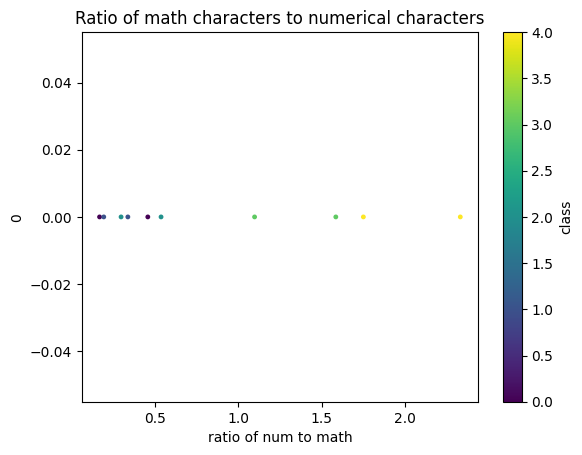

In [17]:
import matplotlib.pyplot as plt
x, y = ratio_list, [0]*len(ratio_list)
z = paper_class
scatter = plt.scatter(x, y, c=paper_class, s=6)
plt.title('Ratio of math characters to numerical characters')

# Add a colorbar to show the mapping
plt.colorbar(scatter, label='class')

# Label axes
plt.xlabel('ratio of num to math')
plt.ylabel('0')

# Show the plot
plt.show()

Eventhough this looks like a good method, this is not that reliable

### Final Model Training

#### Data Preprocessing

In [ ]:
import pandas as pd
cvpr_data = pd.read_csv('Titles/cvpr.csv')
emnlp_data = pd.read_parquet('Titles/emnlp.parquet')
neurips_data = pd.read_parquet('Titles/neurips.parquet')
tmlr_data = pd.read_csv('Titles/tmlr.csv')
kdd_topics = np.load('Titles/kdd.npy')

In [32]:
cvpr_titles = cvpr_data['Title'].dropna().to_numpy()[:len(kdd_topics)]
emnlp_titles = emnlp_data['title'].dropna().to_numpy()[:len(kdd_topics)]
neurips_titles = neurips_data['title'].dropna().to_numpy()[:len(kdd_topics)]
tmlr_titles = tmlr_data['title'].dropna().to_numpy()[:len(kdd_topics)]

In [33]:
from sentence_transformers import SentenceTransformer
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)

In [34]:
cvpr_titles_embeds = [model.encode(i) for i in cvpr_titles]
emnlp_titles_embeds = [model.encode(i) for i in emnlp_titles]
neurips_titles_embeds = [model.encode(i) for i in neurips_titles]
tmlr_titles_embeds = [model.encode(i) for i in tmlr_titles]
kdd_titles_embeds = [model.encode(i) for i in kdd_topics]

In [36]:
titles_vector_base = np.array(cvpr_titles_embeds+emnlp_titles_embeds+kdd_titles_embeds+neurips_titles_embeds+tmlr_titles_embeds)
titles_vector_labels = np.array([i//len(kdd_titles_embeds) for i in range(len(titles_vector_base))])

In [37]:
np.save('KNN_train_data', titles_vector_base)
np.save('KNN_train_labels', titles_vector_labels)

In [38]:
titles_vector_base = np.load('KNN_train_data.npy')
titles_vector_labels = np.load('KNN_train_labels.npy')

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_n_closest_vectors(training_vectors, new_vector, n=1):
    """
    Find the indices of the n closest vectors to the new vector among the training vectors.
    
    Args:
        training_vectors (list or np.ndarray): List or array of training vectors.
        new_vector (np.ndarray): The new vector to compare.
        n (int): Number of closest vectors to find.
    
    Returns:
        list: Indices of the n closest vectors in the training vectors.
    """
    training_vectors = np.array(training_vectors)  # Ensure it's a NumPy array
    new_vector = np.array(new_vector).reshape(1, -1)  # Reshape to match dimensions
    similarities = cosine_similarity(training_vectors, new_vector).flatten()  # Compute cosine similarities
    closest_indices = np.argsort(similarities)[-n:][::-1]  # Get indices of n highest similarities in descending order
    return closest_indices.tolist()

from collections import Counter

def most_frequent_element(lst):
    """
    Find the element with the highest frequency of occurrence in a list.
    
    Args:
        lst (list): Input list of elements.
    
    Returns:
        The element with the highest frequency.
    """
    if not lst:
        return None  # Handle empty list case
    
    counter = Counter(lst)  # Count the frequency of each element
    most_common_element = counter.most_common(1)[0][0]  # Get the element with the highest frequency
    return most_common_element

#### Model testing on labeled data

In [40]:
for i in range(len(abstracts)):
    index = find_n_closest_vectors(titles_vector_base, abstracts[i], n=21)
    print(labels[i])
    l = [titles_vector_labels[i] for i in index]
    print(most_frequent_element(l))

CVPR
0
CVPR
0
EMNLP
1
EMNLP
1
KDD
2
KDD
2
NeurIPS
3
NeurIPS
4
TMLR
4
TMLR
4


We see that it works well and we have verified through other means that this method is pretty reliable

### Final Model function

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def find_n_closest_vectors(training_vectors, new_vector, n=1):
    """
    Find the indices of the n closest vectors to the new vector among the training vectors.
    
    Args:
        training_vectors (list or np.ndarray): List or array of training vectors.
        new_vector (np.ndarray): The new vector to compare.
        n (int): Number of closest vectors to find.
    
    Returns:
        list: Indices of the n closest vectors in the training vectors.
    """
    training_vectors = np.array(training_vectors)  # Ensure it's a NumPy array
    new_vector = np.array(new_vector).reshape(1, -1)  # Reshape to match dimensions
    similarities = cosine_similarity(training_vectors, new_vector).flatten()  # Compute cosine similarities
    closest_indices = np.argsort(similarities)[-n:][::-1]  # Get indices of n highest similarities in descending order
    return closest_indices.tolist()

from collections import Counter

def most_frequent_element(lst):
    """
    Find the element with the highest frequency of occurrence in a list.
    
    Args:
        lst (list): Input list of elements.
    
    Returns:
        The element with the highest frequency.
    """
    if not lst:
        return None  # Handle empty list case
    
    counter = Counter(lst)  # Count the frequency of each element
    most_common_element = counter.most_common(1)[0][0]  # Get the element with the highest frequency
    return most_common_element

def extract_abstract(pdf_path):
    """
    Extracts the title and abstract from a PDF.
    Title: Text from start to '\nAbstract\n'.
    Abstract: Text between '\nAbstract\n' and '1 Introduction'.
    """
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()


    # Extract abstract
    abstract_start = text.find("\nAbstract\n") + len("\nAbstract\n")
    abstract_end = text.find("1 Introduction")
    abstract = text[abstract_start:abstract_end].strip() if abstract_start != -1 and abstract_end != -1 else ""

    return abstract

In [47]:
from sentence_transformers import SentenceTransformer
def predict_conference(pdf_path): # this is the final funciton that gives the predicted conference of the research paper pdf
    titles_vector_base = np.load('KNN_train_data.npy') # Vector store can be used here
    titles_vector_labels = np.load('KNN_train_labels.npy')
    class_label = ['CVPR', 'EMNLP', 'KDD', 'NeurIPS', 'TMLR']
    abstract = extract_abstract(pdf_path)
    model_name = 'all-mpnet-base-v2'
    model = SentenceTransformer(model_name)
    abstract_embed = model.encode(abstract)
    index = find_n_closest_vectors(titles_vector_base, abstract_embed, n=21)
    l = [titles_vector_labels[i] for i in index]
    conference_class = most_frequent_element(l)
    return class_label[conference_class]

The np.save and np.load functions can be replaced by vector stores of some sort which provide the function of storing and retrieving the train vectors for KNN

In [ ]:
pdf_path = r"Data\Reference\Publishable\TMLR\R015.pdf"  # Replace with the path to your PDF file
predicted_conference = predict_conference(pdf_path)
print(predicted_conference)

TMLR


### Rationale provision modification

get_response_from_LLM(prompt) to be filled in

In [4]:
import os
from groq import Groq
def get_response_from_LLM(prompt, api_key): #this function to be filled in with code that would return the response of the LLM for the input prompt
    groq_api_key = api_key

    client = Groq(
        # This is the default and can be omitted
        api_key=groq_api_key,
    )

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="llama-3.3-70b-versatile",
    )

    return chat_completion.choices[0].message.content

In [11]:
def get_rationale_from_LLM(abstract, conference, api_key, n_words=100):
    prompt = f'Why is the research paper with abstract: {abstract} best suited to be published in {conference} conference in less than {n_words} words'
    rationale = get_response_from_LLM(prompt, api_key)
    return rationale

In [10]:
from sentence_transformers import SentenceTransformer
def predict_conference_and_get_rationale(pdf_path, api_key): # this is the final funciton that gives the predicted conference of the research paper pdf
    titles_vector_base = np.load('KNN_train_data.npy') # Vector store can be used here
    titles_vector_labels = np.load('KNN_train_labels.npy')
    class_label = ['CVPR', 'EMNLP', 'KDD', 'NeurIPS', 'TMLR']
    abstract = extract_abstract(pdf_path)
    model_name = 'all-mpnet-base-v2'
    model = SentenceTransformer(model_name)
    abstract_embed = model.encode(abstract)
    index = find_n_closest_vectors(titles_vector_base, abstract_embed, n=21)
    l = [titles_vector_labels[i] for i in index]
    conference_class = most_frequent_element(l)
    conference = class_label[conference_class]
    rationale = get_rationale_from_LLM(abstract, conference)
    return conference, rationale